In [61]:
import os
import sys
import glob

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.database.load_db       as DB
import invisible_cities.io      .pmaps_io      as pmpio
import invisible_cities.io      .mchits_io     as mchio
import invisible_cities.core    .fit_functions as fitf
import invisible_cities.core    .exceptions    as excpt
import invisible_cities.reco    .xy_algorithms as XY

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import measurement_string
from icaro           .core .fit_functions import conditional_labels

In [62]:
%matplotlib inline

plt.rcParams["figure.figsize"] = 12, 8
plt.rcParams[  "font.size"   ] = 20

labels = conditional_labels(with_title=False)

In [63]:
filename_pattern = "$IC_DATA/MC/Kr/old/*.h5"

In [6]:
filenames = glob.glob(os.path.expandvars(filename_pattern))[:1]

pmaps, MChits = {}, {}
for filename in filenames:
    pmaps_ = pmpio.load_pmaps(filename)
    for key in pmaps_: assert key not in pmaps

    pmaps.update(pmaps_)
    mchits = mchio.load_mchits(filename)
    MChits.update(mchits)

In [7]:
DataSiPM = DB.DataSiPM()
xy_sipm  = np.column_stack([DataSiPM.X.values, DataSiPM.Y.values])

In [53]:
def barycenter_peak(peak, **corona_opts):
    sipms = peak.sipms
    IDs   = sipms.ids
    Qs    = sipms.sum_over_times
    return XY.corona(xy_sipm[IDs], Qs, lm_radius=-1, **corona_opts)[0]


def barycenter_MC(hits):
    data = np.array([(hit.X, hit.Y, hit.E) for hit in hits])
    pos  = data[:, :-1]
    Qs   = data[:,  -1]
    return XY.corona(pos, Qs, lm_radius=-1)[0]


def get(array, attr):
    return np.array([getattr(x, attr) for x in array])


def plot_peak(peak, **corona_opts):
    sipms  = peak.sipms
    IDs    = sipms.ids
    Qs     = sipms.sum_over_times
    Xs, Ys = xy_sipm[IDs].T

    s = plt.scatter(Xs, Ys, c=Qs, marker="s")
    b = barycenter_peak(peak, **corona_opts)
    plt.scatter(b.X, b.Y, marker="x", c="r")
    return plt.colorbar(s)


def plot_mc(hits):
    Xs, Ys, Qs = np.array([(hit.X, hit.Y, hit.E) for hit in hits]).T
    plt.scatter(Xs, Ys, c="k", marker="*")
    b = barycenter_MC(hits)
    return b


def diff_str(var="x"):
    return f"${var}_b - {var}_t$" if var != "r" else r"$\sqrt{(x_b - x_t)^2 + (y_b - y_t)^2}$"

def pull_str(var="x"):
    return fr"$\frac{{{var}_b - {var}_t}}{{\sqrt{{\sigma_b^2 + \sigma_t^2}}}}$"


In [54]:
pull_str("x"), diff_str("x"), diff_str("r")

('$\\frac{x_b - x_t}{\\sqrt{\\sigma_b^2 + \\sigma_t^2}}$',
 '$x_b - x_t$',
 '$\\sqrt{(x_b - x_t)^2 + (y_b - y_t)^2}$')

< nsipm = 7 Q = 0.041543301194906235
                    xy = xy(x=-90.46344757080078, y=110.08109283447266) 3dHit = Cluster(-90.46344757080078, 110.08109283447266, -9.425, E=0.041543301194906235)  >

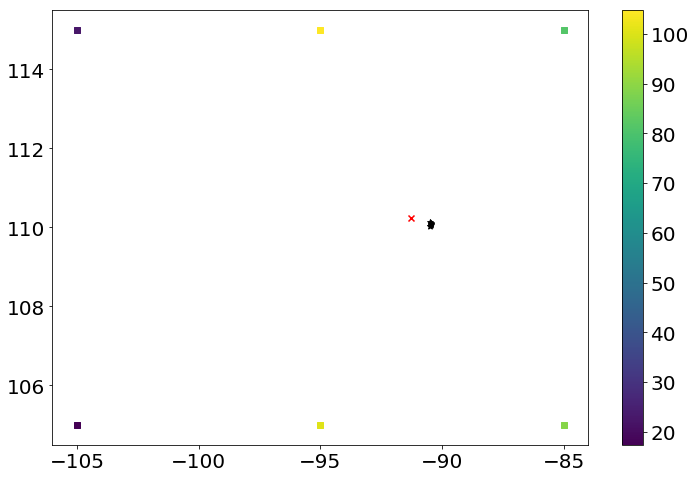

In [24]:
plot_peak(next(iter(pmaps .values())).s2s[0], Qthr=20)
plot_mc  (next(iter(MChits.values())))

In [25]:
print("Si:", barycenter_peak(next(iter(pmaps.values())).s2s[0]))
print()
print("MC:", barycenter_MC(next(iter(MChits.values()))))

Si: < nsipm = 6 Q = 415.9770812988281
                    xy = xy(x=-91.8588357852337, y=110.0241273642087) 3dHit = Cluster(-91.8588357852337, 110.0241273642087, -9.425, E=415.9770812988281)  >

MC: < nsipm = 7 Q = 0.041543301194906235
                    xy = xy(x=-90.46344757080078, y=110.08109283447266) 3dHit = Cluster(-90.46344757080078, 110.08109283447266, -9.425, E=0.041543301194906235)  >


In [27]:
datab = []
datat = []

Qthr = 10
for evt, hits in MChits.items():
    if evt not in pmaps or len(pmaps[evt].s2s) != 1: continue
    try:
        peak = pmaps[evt].s2s[0]
        datab.append(barycenter_peak(peak, Qthr=Qthr))
        datat.append(barycenter_MC  (hits           ))
    except (KeyError, excpt.SipmEmptyListAboveQthr):
        pass

In [28]:
Xb = get(datab, "X")
Yb = get(datab, "Y")
Xt = get(datat, "X")
Yt = get(datat, "Y")

Nb = get(datab, "nsipm")
Nt = get(datat, "nsipm")

sXb = get(datab, "Xrms") / Nb**0.5
sYb = get(datab, "Yrms") / Nb**0.5
sXt = get(datat, "Xrms") / Nt**0.5
sYt = get(datat, "Yrms") / Nt**0.5

Rb = (Xb**2 + Yb**2)**0.5
Rt = (Xt**2 + Yt**2)**0.5

In [43]:
diff_x = Xb - Xt
pull_x = diff_x  / (sXb**2 + sXt**2)**0.5
diff_y = Yb - Yt
pull_y = diff_y  / (sYb**2 + sYt**2)**0.5
diff_r = np.sqrt(diff_x**2 + diff_y**2)

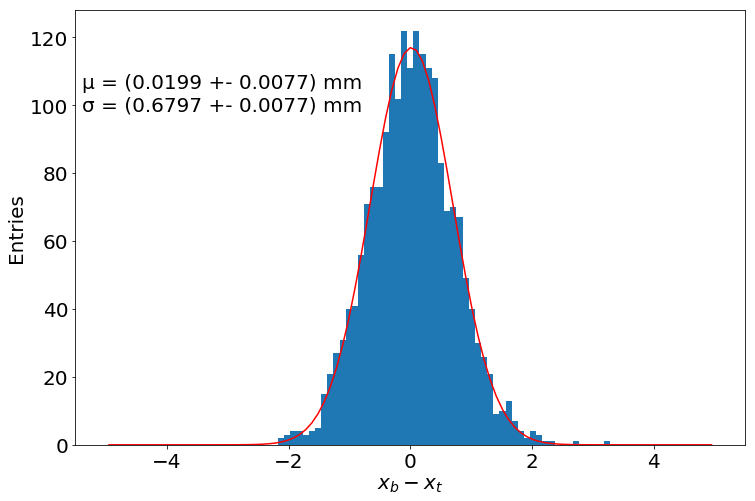

In [68]:
y, x, _ = hist(diff_x, np.linspace(-5, 5, 100))
f = fitf.fit(fitf.gauss, x, y, (1e4, 0, 1))
plt.plot(x, f.fn(x), "r")
plt.text(plt.xlim()[0] + 0.1, plt.ylim()[1]/1.3,
         "µ = ({}) mm\nσ = ({}) mm".format(measurement_string(f.values[1], f.errors[1]),
                                           measurement_string(f.values[2], f.errors[2])))
labels(diff_str("x"), "Entries", "$diff_x$")

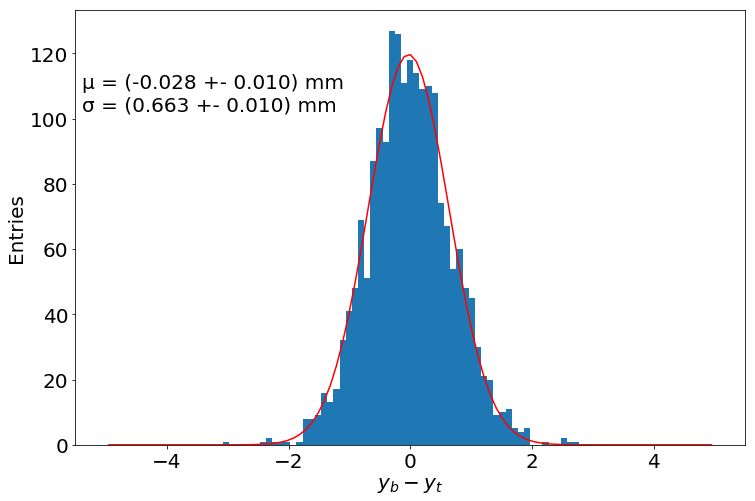

In [69]:
y, x, _ = hist(diff_y, np.linspace(-5, 5, 100))
f = fitf.fit(fitf.gauss, x, y, (1e4, 0, 1))
plt.plot(x, f.fn(x), "r")
plt.text(plt.xlim()[0] + 0.1, plt.ylim()[1]/1.3,
         "µ = ({}) mm\nσ = ({}) mm".format(measurement_string(f.values[1], f.errors[1]),
                                           measurement_string(f.values[2], f.errors[2])))
labels(diff_str("y"), "Entries", "$diff_y$")

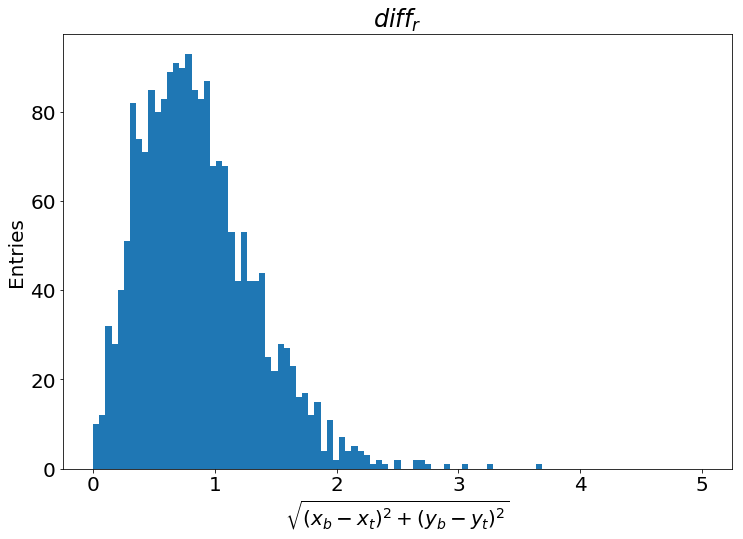

In [55]:
y, x, _ = hist(diff_r, np.linspace(0, 5, 100))
labels(diff_str("r"), "Entries", "$diff_r$")

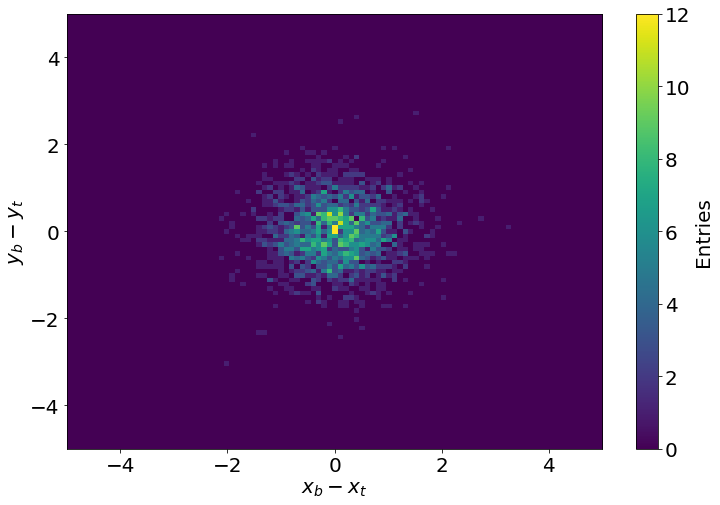

In [70]:
hist2d(diff_x, diff_y, (np.linspace(-5, 5, 100),
                        np.linspace(-5, 5, 100)))
plt.colorbar().set_label("Entries")
labels(diff_str("x"), diff_str("y"), "$diff_y$ vs $diff_x$")

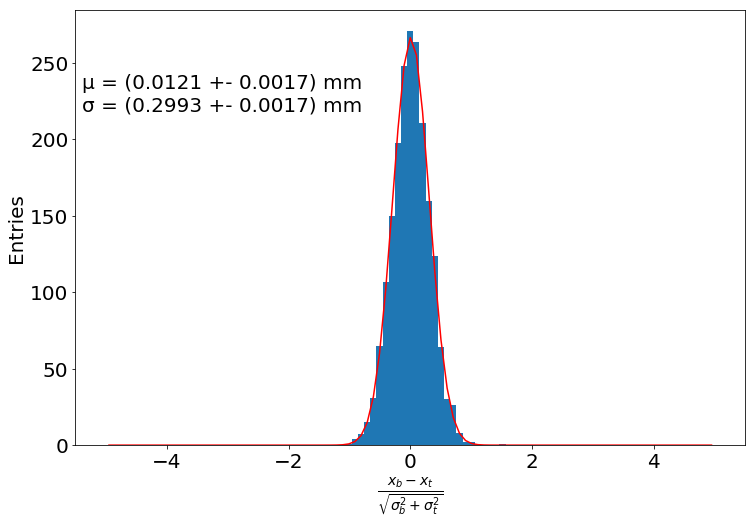

In [74]:
y, x, _ = hist(pull_x, np.linspace(-5, 5, 100))
f = fitf.fit(fitf.gauss, x, y, (1e4, 0, 1))
plt.plot(x, f.fn(x), "r")
plt.text(plt.xlim()[0] + 0.1, plt.ylim()[1]/1.3,
         "µ = ({}) mm\nσ = ({}) mm".format(measurement_string(f.values[1], f.errors[1]),
                                           measurement_string(f.values[2], f.errors[2])))
labels(pull_str("x"), "Entries", "$pull_x$")

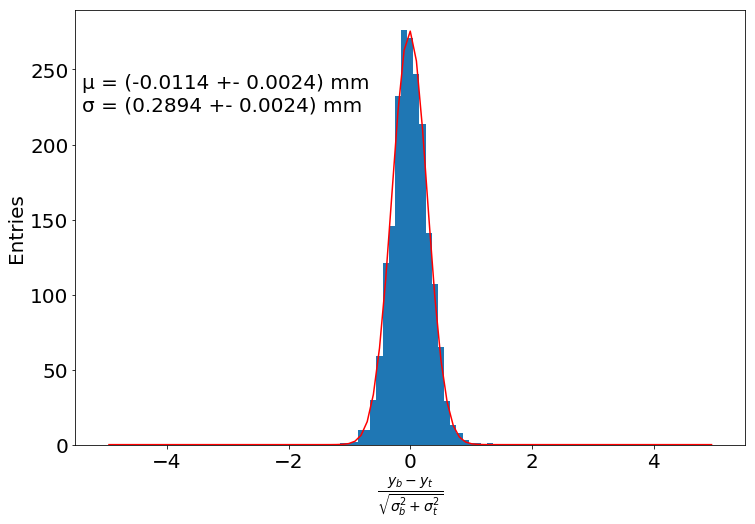

In [75]:
y, x, _ = hist(pull_y, np.linspace(-5, 5, 100))
f = fitf.fit(fitf.gauss, x, y, (1e4, 0, 1))
plt.plot(x, f.fn(x), "r")
plt.text(plt.xlim()[0] + 0.1, plt.ylim()[1]/1.3,
         "µ = ({}) mm\nσ = ({}) mm".format(measurement_string(f.values[1], f.errors[1]),
                                           measurement_string(f.values[2], f.errors[2])))
labels(pull_str("y"), "Entries", "$pull_y$")

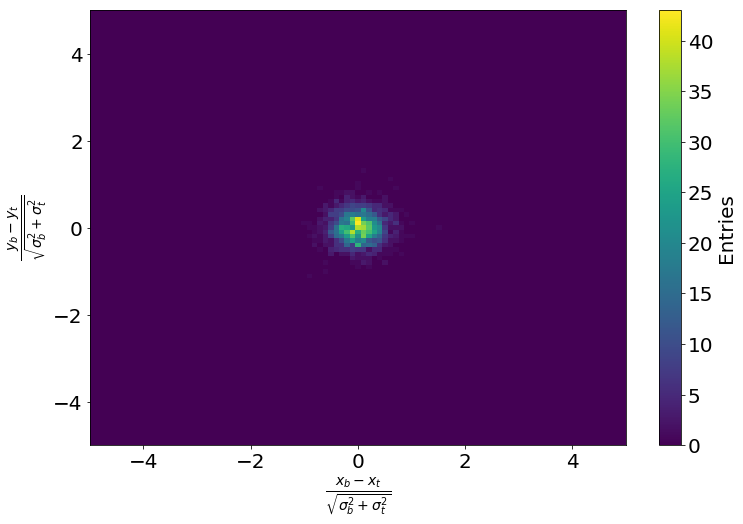

In [76]:
hist2d(pull_x, pull_y, (np.linspace(-5, 5, 100),
                        np.linspace(-5, 5, 100)))
plt.colorbar().set_label("Entries")
labels(pull_str("x"), pull_str("y"), "$pull_y$ vs $pull_x$")

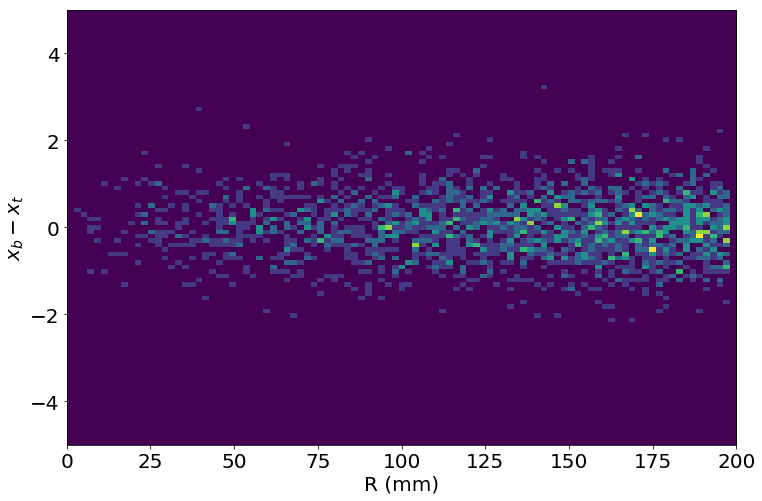

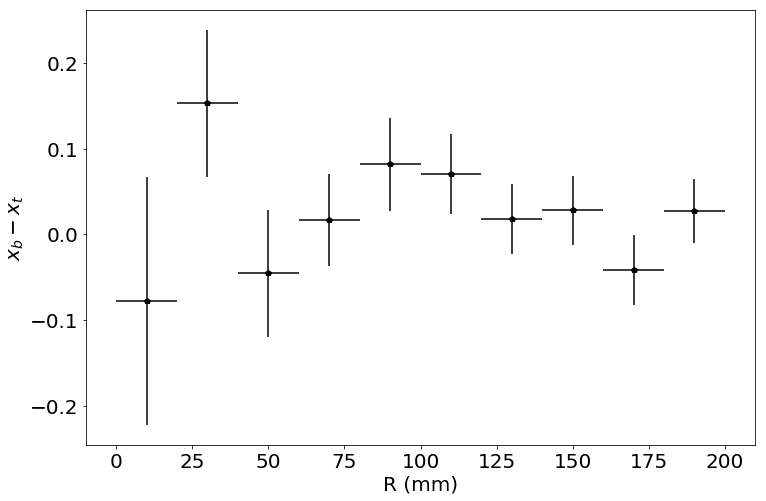

In [77]:
z, x, y, _ = hist2d(Rt, diff_x, (np.linspace(0, 200, 100),
                                 np.linspace(-5, 5, 100)))
labels("R (mm)", diff_str("x"), "$diff_x$ vs R")

plt.figure()
x, y, ye = fitf.profileX(Rt, diff_x, 10, (0, 200))
xe = np.diff(x)[0] / 2
plt.errorbar(x, y, ye, xe, fmt="kp")
labels("R (mm)", diff_str("x"), "$diff_x$ vs R")

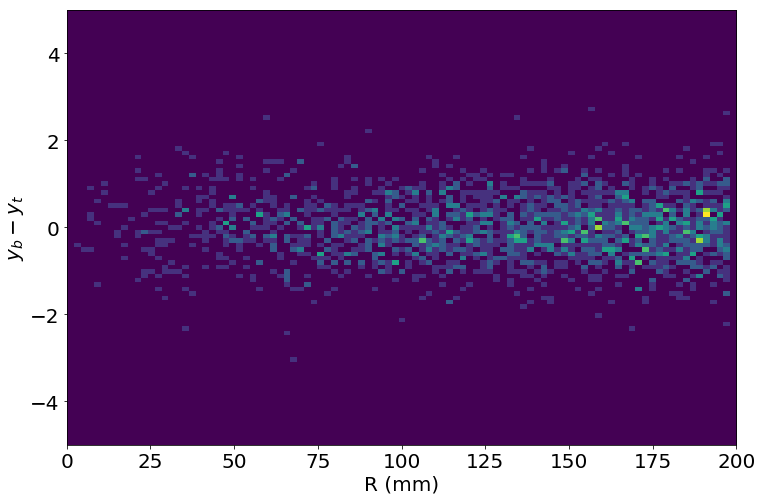

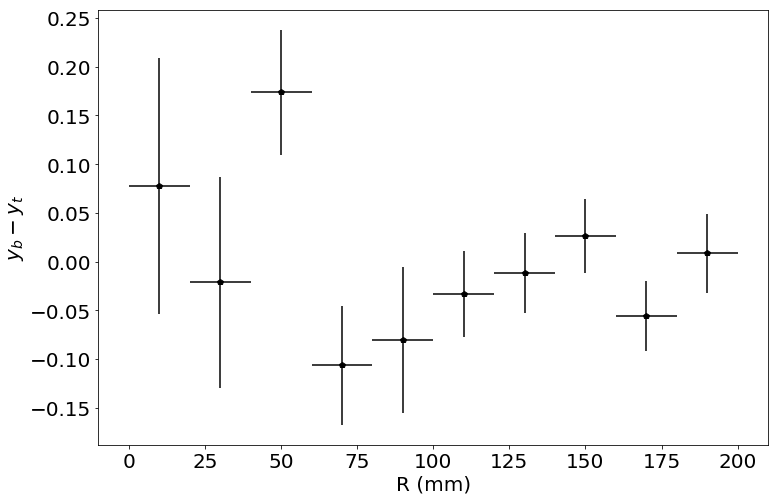

In [78]:
z, x, y, _ = hist2d(Rt, diff_y, (np.linspace(0, 200, 100),
                                 np.linspace(-5, 5, 100)))
labels("R (mm)", diff_str("y"), "$diff_y$ vs R")

plt.figure()
x, y, ye = fitf.profileX(Rt, diff_y, 10, (0, 200))
xe = np.diff(x)[0] / 2
plt.errorbar(x, y, ye, xe, fmt="kp")
labels("R (mm)", diff_str("y"), "$diff_y$ vs R")

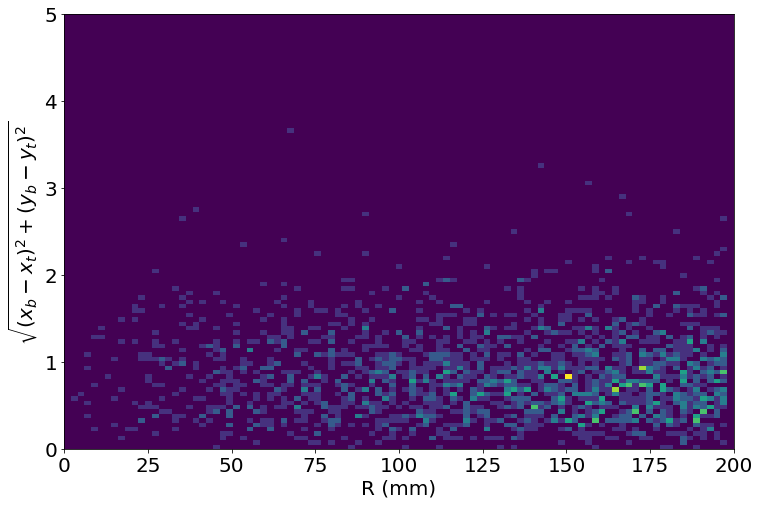

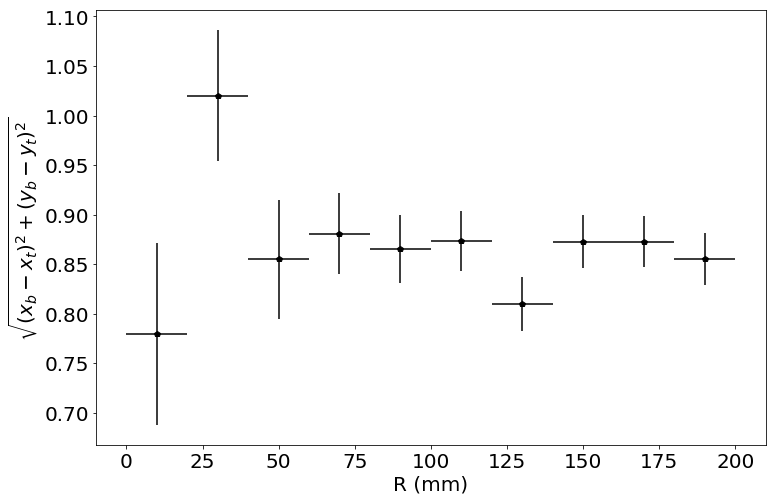

In [79]:
z, x, y, _ = hist2d(Rt, diff_r, (np.linspace(0, 200, 100),
                                 np.linspace(0,   5, 100)))
labels("R (mm)", diff_str("r"), "$diff_r$ vs R")

plt.figure()
x, y, ye = fitf.profileX(Rt, diff_r, 10, (0, 200))
xe = np.diff(x)[0] / 2
plt.errorbar(x, y, ye, xe, fmt="kp")
labels("R (mm)", diff_str("r"), "$diff_r$ vs R")

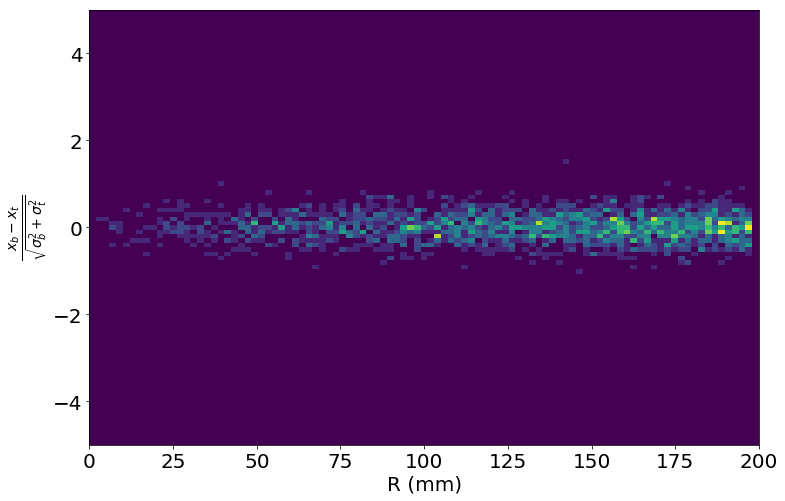

In [80]:
z, x, y, _ = hist2d(Rt, pull_x, (np.linspace(0, 200, 100),
                                 np.linspace(-5, 5, 100)))
labels("R (mm)", pull_str("x"), "$pull_x$ vs R")

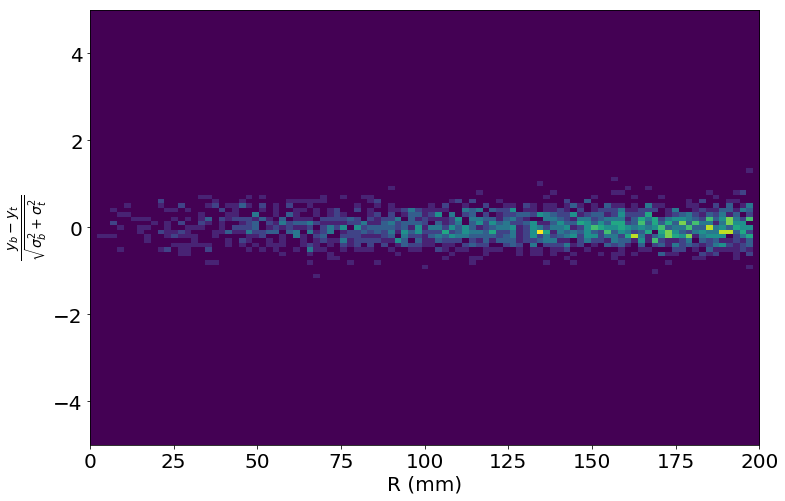

In [81]:
z, x, y, _ = hist2d(Rt, pull_y, (np.linspace(0, 200, 100),
                                 np.linspace(-5, 5, 100)))
labels("R (mm)", pull_str("y"), "$pull_y$ vs R")

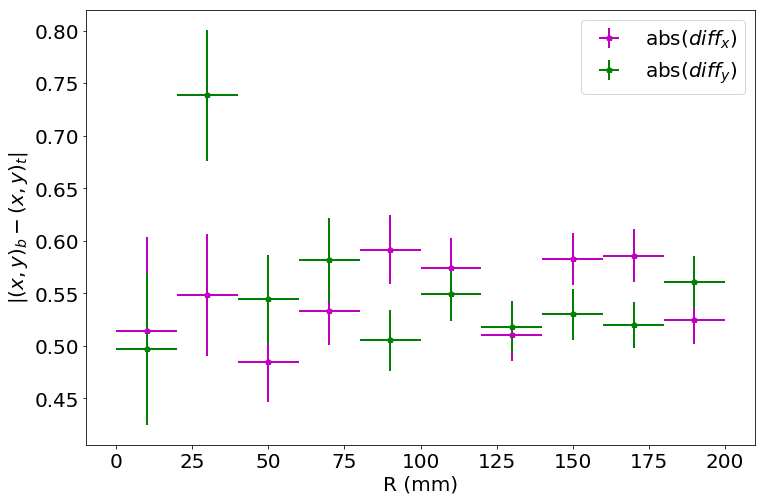

In [82]:
r, x, u_x = fitf.profileX(Rt, np.abs(diff_x), 10, xrange=(0,200))
_, y, u_y = fitf.profileX(Rt, np.abs(diff_y), 10, xrange=(0,200))

plt.errorbar(r, x, u_x, np.diff(r)[0] * 0.5, "mp", label="abs($diff_x$)", lw=2)
plt.errorbar(r, y, u_y, np.diff(r)[0] * 0.5, "gp", label="abs($diff_y$)", lw=2)
plt.legend()
labels("R (mm)", "|{}|".format(diff_str("(x,y)")), "$diff$ vs R")

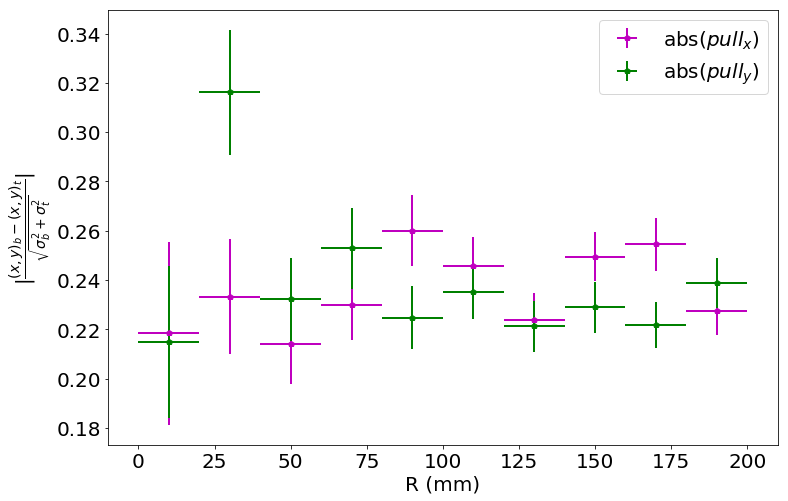

In [83]:
r, x, u_x = fitf.profileX(Rt, np.abs(pull_x), 10, xrange=(0,200))
_, y, u_y = fitf.profileX(Rt, np.abs(pull_y), 10, xrange=(0,200))

plt.errorbar(r, x, u_x, np.diff(r)[0] * 0.5, "mp", label="abs($pull_x$)", lw=2)
plt.errorbar(r, y, u_y, np.diff(r)[0] * 0.5, "gp", label="abs($pull_y$)", lw=2)
plt.legend()
labels("R (mm)", "|{}|".format(pull_str("(x,y)")), "$pull$ vs R")